In [9]:
import coincident
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar
import contextily as ctx
import sys
import os
sys.path.append(os.path.abspath('/home/jehayes/gda_final/ATL06_LaserLottery/misc'))
from nlcd_plot import nlcd_labels, nlcd_colors
import sr_wrapper
import stac_helper
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Identify a USGS 3DEP site of interest

In [10]:
gf_flights = gpd.read_file("/home/jehayes/gda_final/ATL06_LaserLottery/test_data/wesm_2021_bboxes_30d_esa.geojson")
aoi = gf_flights.iloc[[0]]
gf_wesm = coincident.search.wesm.load_by_fid(fids=aoi.fid.values)

In [ ]:
# yes i hardcode in a file to cherry pick a site but here's that metadata
gf_wesm

,workunit,workunit_id,project,project_id,start_datetime,end_datetime,ql,spec,p_method,dem_gsd_meters,...,seamless_category,seamless_reason,lpc_link,sourcedem_link,metadata_link,geometry,collection,datetime,dayofyear,duration
0,OR_McKenzieRiver_1_2021,220421,OR_McKenzieRiver_2021_B21,220424,2021-07-04,2021-07-06,QL 1,USGS Lidar Base Specification 2.1,linear-mode lidar,0.4572,...,Meets,Meets 3DEP seamless DEM requirements,https://rockyweb.usgs.gov/vdelivery/Datasets/S...,http://prd-tnm.s3.amazonaws.com/index.html?pre...,http://prd-tnm.s3.amazonaws.com/index.html?pre...,"MULTIPOLYGON (((-122.93477 44.00285, -122.9347...",3DEP,2021-07-05,186,2


Get ICESat-2 tracks within +-12 days of 3DEP collection

Why 12? Because that's when the second granule is acquired (cherry picked arbitrarily)

In [3]:
atl06_items = stac_helper.get_atl06_stac(aoi.iloc[0], window_days=12)
gf_atl06_stac = stac_helper.to_geopandas(atl06_items[0].item_collection())

In [8]:
gf_atl06_stac

,assets,bbox,collection,geometry,id,links,stac_extensions,stac_version,type,datetime,end_datetime,start_datetime,dayofyear
0,{'24/ATL06_20210624003626_00061202_006_01': {'...,"{'xmin': -125.61423, 'ymin': 35.82996, 'xmax':...",ATL06_006,"POLYGON ((-125.39382 59.54551, -125.61423 59.5...",SC:ATL06.006:272416853,[{'href': 'https://cmr.earthdata.nasa.gov/stac...,[],1.0.0,Feature,2021-06-24 00:38:44.185000+00:00,2021-06-24 00:44:55.763000+00:00,2021-06-24 00:38:44.185000+00:00,175
1,{'26/ATL06_20210626124356_00441206_006_01': {'...,"{'xmin': -123.56884, 'ymin': 38.12829, 'xmax':...",ATL06_006,"POLYGON ((-120.15698 59.53431, -120.37752 59.5...",SC:ATL06.006:272422736,[{'href': 'https://cmr.earthdata.nasa.gov/stac...,[],1.0.0,Feature,2021-06-26 12:43:55.642000+00:00,2021-06-26 12:49:31.271000+00:00,2021-06-26 12:43:55.642000+00:00,177


In [ ]:
gf_atl06_points = sr_wrapper.get_atl06(
    gf_atl06_stac,
    window_start = atl06_items[1],
    window_end = atl06_items[2],
    aoi_geometry= aoi.iloc[0].geometry,
)

In [6]:
gf_wesm = gf_wesm.to_crs(gf_atl06_points.crs)
gf_atl06_points = gf_atl06_points.clip(gf_wesm.geometry)
print("CRS: {}".format(gf_atl06_points.crs))
print("Reference Ground Tracks: {}".format(gf_atl06_points["rgt"].unique()))
print("Cycles: {}".format(gf_atl06_points["cycle"].unique()))
print("Received {} elevations".format(gf_atl06_points.shape[0]))

CRS: EPSG:7912
Reference Ground Tracks: [ 6 44]
Cycles: [12]
Received 2490 elevations


Plot geographical context

In [7]:
fn_states = 'https://raw.githubusercontent.com/PublicaMundi/MappingAPI/refs/heads/master/data/geojson/us-states.json'
gf_states = gpd.read_file(fn_states)
hi_ak_pr = ["Alaska", "Hawaii", "Puerto Rico"]
gf_conus = gf_states[~gf_states["name"].isin(hi_ak_pr)].to_crs(gf_atl06_points.crs)
gf_conus_3857 = gf_conus.to_crs(epsg=3857)

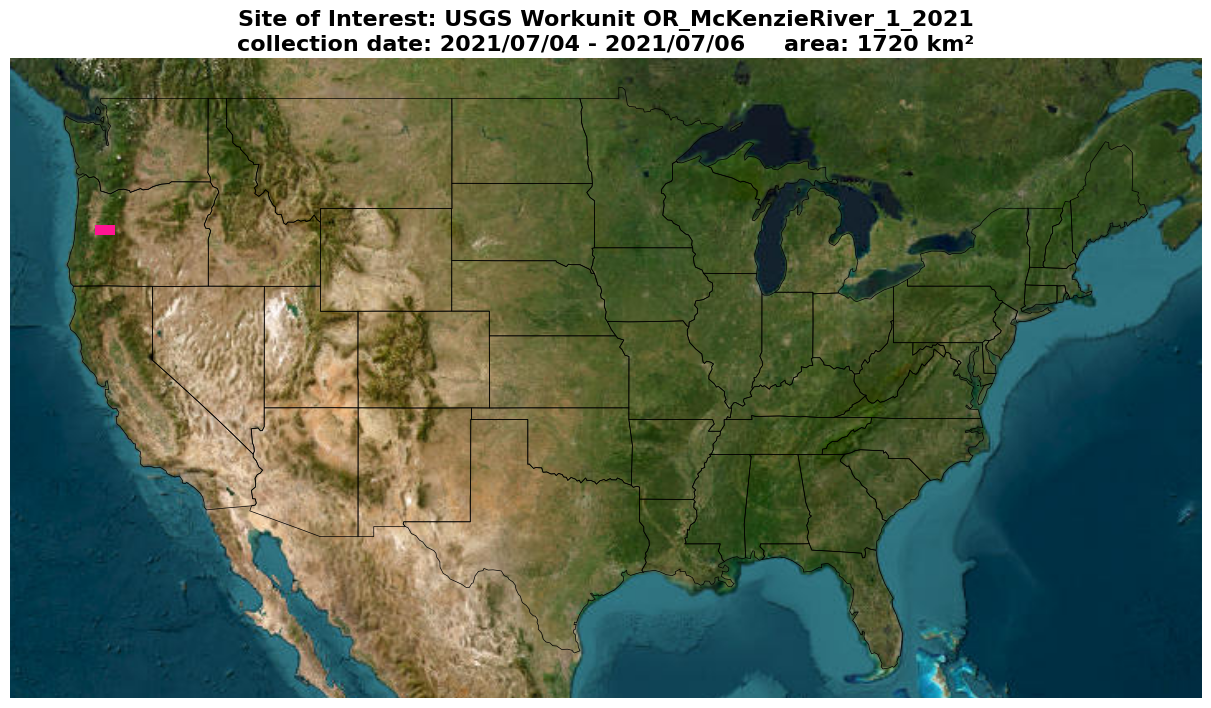

In [8]:
f, ax = plt.subplots(figsize=(12,7), layout='constrained')
gf_conus_3857.plot(ax=ax, facecolor='none', 
              edgecolor='black', linewidth=0.5)
aoi.to_crs(3857).plot(ax=ax, color="deeppink")
ctx.add_basemap(ax=ax, crs=gf_conus_3857.crs,
                source=ctx.providers.Esri.WorldImagery,
                attribution=False)
ax.set(xticks=[], yticks=[], 
       xlabel="", ylabel="", 
       frame_on=False)
ax.set_aspect('equal')
ax.set_title("Site of Interest: USGS Workunit OR_McKenzieRiver_1_2021\ncollection date: 2021/07/04 - 2021/07/06     area: 1720 km²",
             fontsize=16, fontweight='bold');

In [9]:
crs_utm = gf_wesm.estimate_utm_crs()
gf_wesm_utm = gf_wesm.to_crs(crs_utm)
gf_atl06_stac_utm = gf_atl06_stac.to_crs(crs_utm)

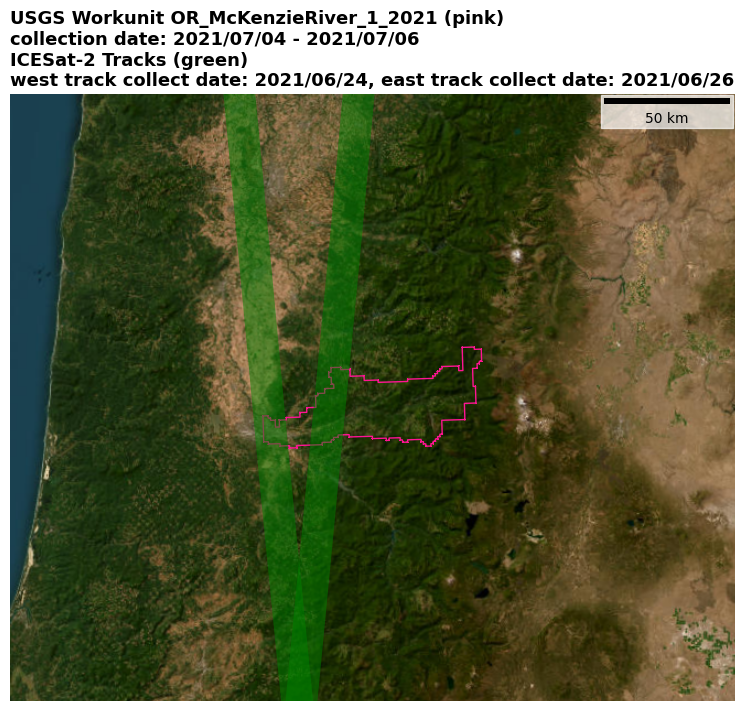

In [10]:
bounds = gf_wesm_utm.total_bounds
f, ax = plt.subplots(figsize=(12,7), layout='constrained')
gf_wesm_utm.plot(ax=ax, facecolor='none', 
              edgecolor='deeppink', linewidth=1)
gf_atl06_stac_utm.plot(ax=ax, color="green",alpha=0.5)
scalebar = ScaleBar(1, location='upper right', box_alpha=0.7)
ax.add_artist(scalebar)
ax.set_xlim(bounds[0]-1e5, bounds[2]+1e5)
ax.set_ylim(bounds[1]-1e5, bounds[3]+1e5)
ctx.add_basemap(ax=ax, crs=gf_wesm_utm.crs,
                source=ctx.providers.Esri.WorldImagery,
                attribution=False)
ax.set(xticks=[], yticks=[], 
       xlabel="", ylabel="", 
       frame_on=False)
ax.set_aspect('equal')
ax.set_title("USGS Workunit OR_McKenzieRiver_1_2021 (pink)\ncollection date: 2021/07/04 - 2021/07/06\nICESat-2 Tracks (green)\nwest track collect date: 2021/06/24, east track collect date: 2021/06/26",
             fontsize=13, fontweight='bold', loc='left');